In [117]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from autoeq.frequency_response import FrequencyResponse
#from scipy.signal import savgol_filter, find_peaks, minimum_phase, firwin2
from scipy.signal import find_peaks

# Aiming For Target

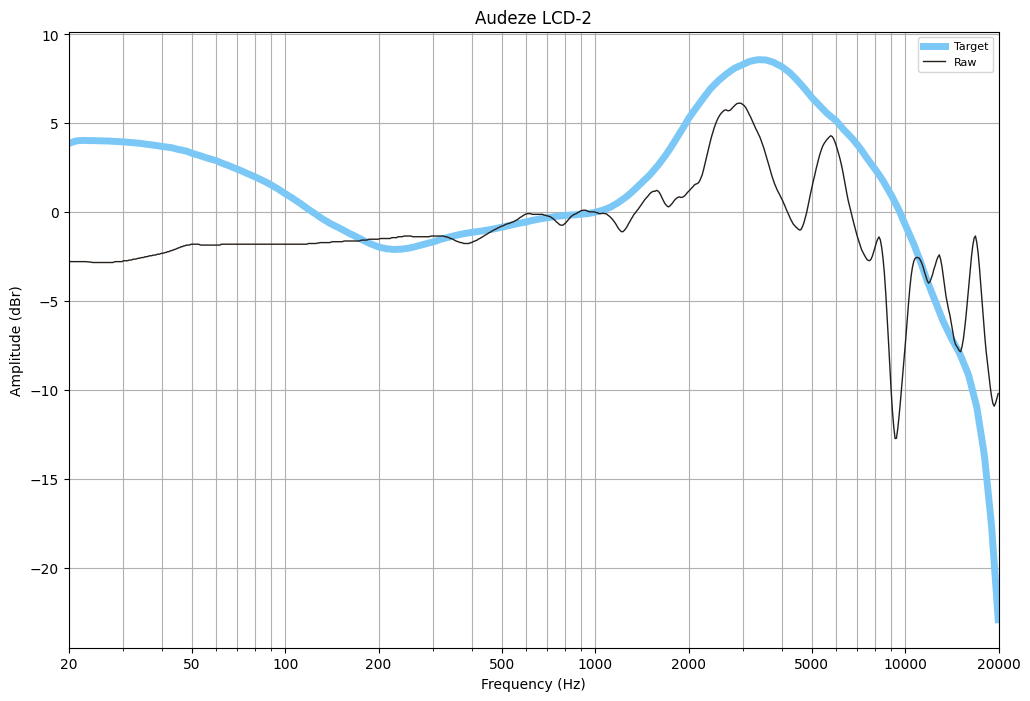

In [92]:
fr = FrequencyResponse.read_from_csv('Audeze LCD-2.csv')
target = FrequencyResponse.read_from_csv('harman_over-ear_2018.csv')
fr.compensate(target)
fig, ax = fr.plot_graph(
    raw_plot_kwargs={'color': '#251f1b'},
    target_plot_kwargs={'color': '#7bc8f6'},
    error_plot_kwargs={'color': '#ff5b3d'},
    equalized_plot_kwargs={'color': '#ded400'},
    error=False
)

fill = ax.fill_between([], [], [], color='#ff5b3d')
n_frames = 30
fps = 30
    
def animate(i):
    if i < n_frames // 2:
        y0 = fr.raw
        y1 = y0 - fr.error * min(n_frames // 2, i) / (n_frames // 2)
    else:
        y1 = fr.target * max(0, (1 - (i - n_frames // 2) / (n_frames // 2)))
        y0 = y1 + fr.error * min(n_frames // 2, i) / (n_frames // 2)
    ax.collections.clear()
    ax.fill_between(fr.frequency, y0, y1, color='#ff5b3d', label='Error')
    ax.set_ylim([-15, 15])
    ax.legend()
    return fill,

anim = FuncAnimation(fig, animate, frames=n_frames+30, interval=0, blit=True, repeat_delay=1000, repeat=False)

plt.show()
anim.save('aim_for_target.gif', fps=fps)

## Absolute Levels

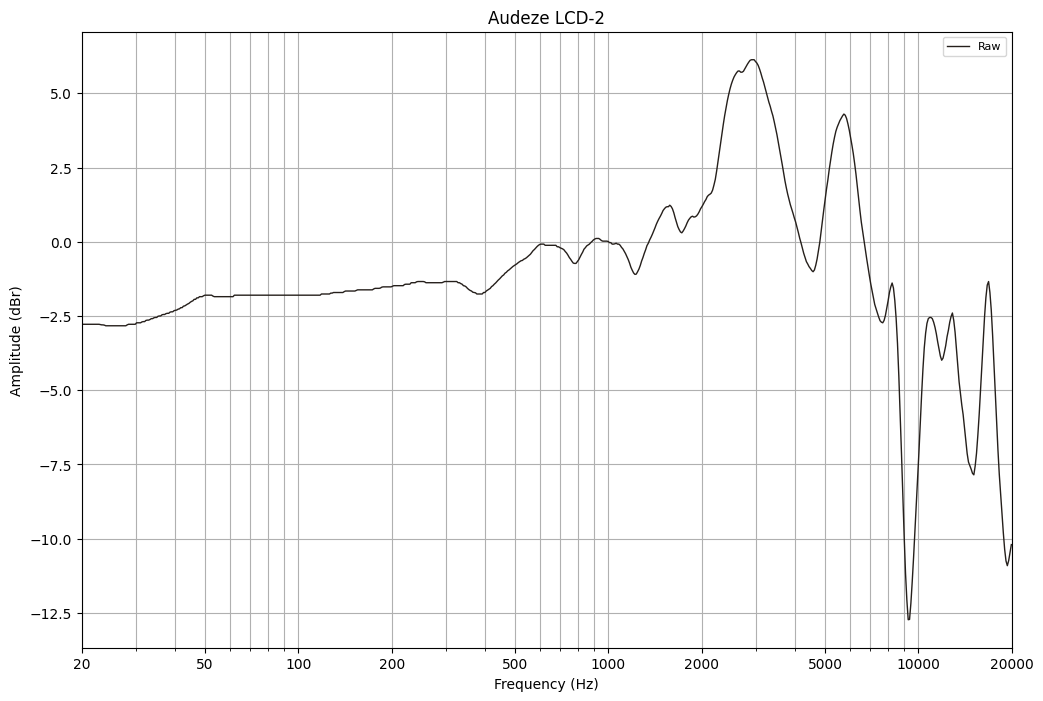

In [94]:
fr = FrequencyResponse.read_from_csv('Audeze LCD-2.csv')
target = FrequencyResponse.read_from_csv('harman_over-ear_2018.csv')
fr.compensate(target)
fig, ax = fr.plot_graph(
    raw_plot_kwargs={'color': '#251f1b'},
    target_plot_kwargs={'color': '#7bc8f6'},
    error_plot_kwargs={'color': '#ff5b3d'},
    equalized_plot_kwargs={'color': '#ded400'},
    target=False,
    error=False
)
ax.set_ylim([-15, 15])

error_target = fr.error + np.mean(fr.error[np.logical_and(fr.frequency >= 100, fr.frequency <= 10000)])

target, = ax.plot([], [], color='#7bc8f6', linewidth=5, label='Target')
error, = ax.plot([], [], color='#ff5b3d', label='Error')
mean, = ax.plot([], [], '--', color='#ff5b3d', label='Average Error')
ax.legend(loc='upper left')
n_frames = 30
fps = 30
    
def animate(i):
    delta = (fr.error - error_target) * min(1, (i / n_frames))
    error.set_data(fr.frequency, fr.error + delta)
    target.set_data(fr.frequency, fr.target - delta)
    mean.set_data(fr.frequency,  np.mean(fr.error[np.logical_and(fr.frequency >= 100, fr.frequency <= 10000)]) + delta)
    return error, target
    #return error,

anim = FuncAnimation(fig, animate, frames=n_frames+30, interval=0, blit=True, repeat_delay=1000, repeat=False)

plt.show()
anim.save('absolute_levels.gif', fps=fps)

## Smoothing

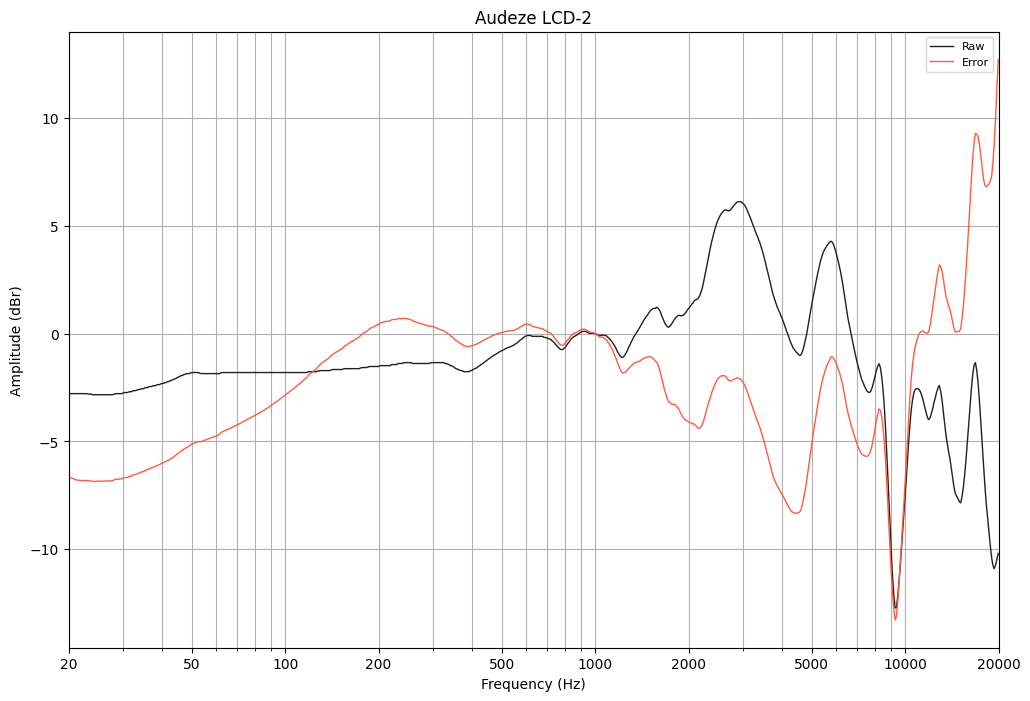

In [90]:
fr = FrequencyResponse.read_from_csv('Audeze LCD-2.csv')
target = FrequencyResponse.read_from_csv('harman_over-ear_2018.csv')
fr.compensate(target)
fr.smoothen_fractional_octave(
    window_size=1/3,
    iterations=1,
    treble_window_size=1,
    treble_iterations=1,
    treble_f_lower=1000,
    treble_f_upper=8000)

fig, ax = fr.plot_graph(
    raw_plot_kwargs={'color': '#251f1b'},
    error_plot_kwargs={'color': '#ff5b3d'},
    target=False,
    smoothed=False,
    error_smoothed=False
)
ax.set_ylim([-15, 15])

smoothed, = ax.plot([], [], color='#9e9494', linewidth=5, zorder=-1)
error_smoothed, = ax.plot([], [], color='#ffd4cc', linewidth=5, zorder=-2)

n_frames = 30
fps = 30

def animate(i):
    n = int(min(len(fr.frequency), len(fr.frequency) * (i / n_frames)))
    smoothed.set_data(fr.frequency[:n], fr.smoothed[:n])
    error_smoothed.set_data(fr.frequency[:n], fr.error_smoothed[:n])
    return smoothed, error_smoothed

anim = FuncAnimation(fig, animate, frames=n_frames+30, interval=0, blit=True, repeat_delay=1000, repeat=False)

plt.show()
anim.save('smoothing.gif', fps=fps)

## Max Gain

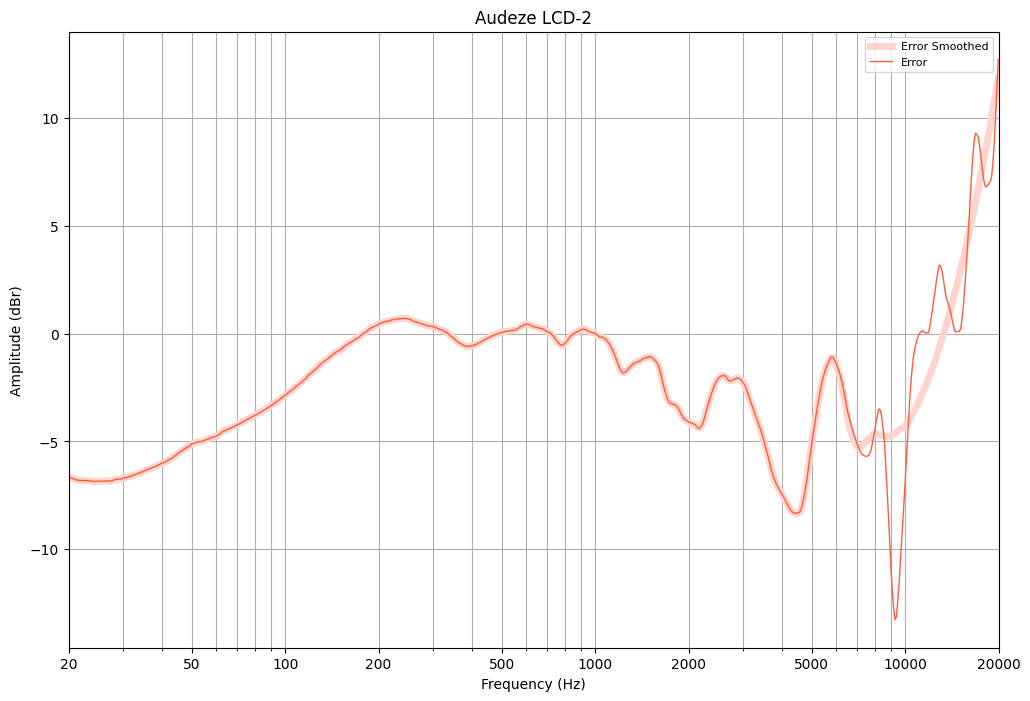

In [123]:
fr = FrequencyResponse.read_from_csv('Audeze LCD-2.csv')
target = FrequencyResponse.read_from_csv('harman_over-ear_2018.csv')
fr.compensate(target)

fr.smoothen_fractional_octave(
    window_size=1/12,
    iterations=1,
    treble_window_size=2,
    treble_iterations=1,
    treble_f_lower=6000,
    treble_f_upper=8000)

fr2 = fr.copy()

fr.equalize(
    max_slope=99, max_gain=4, concha_interference=False, treble_f_lower=6000,
    treble_f_upper=8000, treble_gain_k=1)
fr2.equalize(
    max_slope=99, max_gain=99, concha_interference=False, treble_f_lower=6000,
    treble_f_upper=8000, treble_gain_k=1)

#delta = np.mean(fr.error[np.logical_and(fr.frequency >= 100, fr.frequency <= 10000)])
#fr.error += delta
#fr.error_smoothed += delta

fig, ax = fr.plot_graph(
    raw_plot_kwargs={'color': '#251f1b'},
    smoothed_plot_kwargs={'color': '#9e9494'},
    error_plot_kwargs={'color': '#ff5b3d'},
    error_smoothed_plot_kwargs={'color': '#ffd4cc'},
    raw=False,
    smoothed=False,
    target=False,
    equalization=False,
    equalized=False,
)
ax.plot([20, 20e3], [4, 4], '--', color='grey', label='Max Gain')

equalized, = ax.plot([], [], color='#ded400', linewidth=2, label='Limited')
unlimited, = ax.plot([], [], '--', color='#ded400', linewidth=2, label='Unlimited')
ax.legend()

n_frames = 30
fps = 30

def animate(i):
    n = int(min(len(fr.frequency), len(fr.frequency) * (i / n_frames)))
    equalized.set_data(fr.frequency[:n], fr.equalization[:n])
    unlimited.set_data(fr.frequency[:n], fr2.equalization[:n])
    return equalized,

anim = FuncAnimation(fig, animate, frames=n_frames+30, interval=0, blit=True, repeat_delay=1000, repeat=False)

plt.show()
anim.save('max_gain.gif', fps=fps)

## Avoiding Spikes

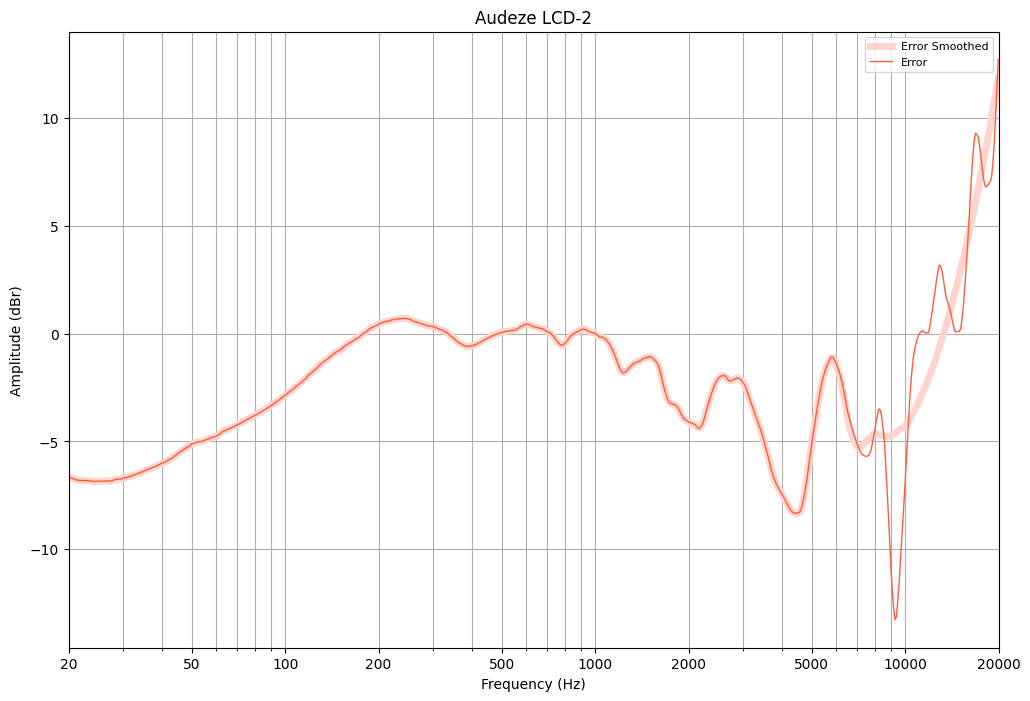

In [142]:
fr = FrequencyResponse.read_from_csv('Audeze LCD-2.csv')
target = FrequencyResponse.read_from_csv('harman_over-ear_2018.csv')
fr.compensate(target)

fr.smoothen_fractional_octave(
    window_size=1/12,
    iterations=1,
    treble_window_size=2,
    treble_iterations=1,
    treble_f_lower=6000,
    treble_f_upper=8000)

fig, ax = fr.plot_graph(
    raw_plot_kwargs={'color': '#251f1b'},
    smoothed_plot_kwargs={'color': '#9e9494'},
    error_plot_kwargs={'color': '#ff5b3d'},
    error_smoothed_plot_kwargs={'color': '#ffd4cc'},
    raw=False,
    smoothed=False,
    target=False,
    equalization=False,
    equalized=False,
)

max_slope = 6
max_slope_decay = 0.0
concha_interference = False
treble_f_lower = 6000
treble_f_upper = 8000
max_gain = 18

x = np.array(fr.frequency)
y = np.array(-fr.error_smoothed)  # Inverse of the smoothed error

# Find peaks and notches
peak_inds, peak_props = find_peaks(y, prominence=1)
dip_inds, dip_props = find_peaks(-y, prominence=1)

limit_free_mask = fr.protection_mask(y, peak_inds, dip_inds)
if concha_interference:
    # 8 kHz - 11.5 kHz should not be limit free zone
    limit_free_mask[np.logical_and(x >= 8000, x <= 11500)] = False

# Find rtl start index
rtl_start = fr.find_rtl_start(y, peak_inds, dip_inds)

# Find ltr and rtl limitations
# limited_ltr is y but with slopes limited when traversing left to right
# clipped_ltr is boolean mask for limited samples when traversing left to right
# limited_rtl is found using ltr algorithm but with flipped data
limited_ltr, clipped_ltr, regions_ltr = fr.limited_ltr_slope(
    x, y, max_slope, max_slope_decay=max_slope_decay, start_index=0, peak_inds=peak_inds,
    limit_free_mask=limit_free_mask, concha_interference=concha_interference)
limited_rtl, clipped_rtl, regions_rtl = fr.limited_rtl_slope(
    x, y, max_slope, max_slope_decay=max_slope_decay, start_index=rtl_start, peak_inds=peak_inds,
    limit_free_mask=limit_free_mask, concha_interference=concha_interference)

# ltr and rtl limited curves are combined with min function
combined = fr.__class__(name='limiter', frequency=x, raw=np.min(np.vstack([limited_ltr, limited_rtl]), axis=0))

# Gain can be reduced in the treble region
# Clip positive gain to max gain
combined.raw = np.min(np.vstack([combined.raw, np.ones(combined.raw.shape) * max_gain]), axis=0)
# Smoothen the curve to get rid of hard kinks
combined.smoothen_fractional_octave(window_size=1 / 5, treble_window_size=1 / 5)

min_f = 1000
start_ix = np.argmin(np.abs(fr.frequency - min_f))
f = fr.frequency[start_ix:]
y = y[start_ix:]
limited_ltr = limited_ltr[start_ix:]
limited_rtl = limited_rtl[start_ix:]
combined.smoothed = combined.smoothed[start_ix:]


unlimited, = ax.plot([], [], color='C0', linewidth=2, label='Unlimited')
limited_ltr_line, = ax.plot([], [], '--', color='C1', linewidth=2, label='Limited Left to Right')
limited_rtl_line, = ax.plot([], [], '--', color='C5', linewidth=2, label='Limited Right to Left')
combined_line, = ax.plot([], [], color='C3', linewidth=2, label='Combined')
ax.legend()
ax.set_xlim([min_f, 20000])
ax.set_ylim([-10, 10])

n_frames = 240
fps = 30

def animate(i):
    if i < n_frames * (1 / 4):
        n = int(len(f) * ((i - n_frames * 0 / 4) / (n_frames / 4)))
        unlimited.set_data(f[:n], y[:n])
    elif i < n_frames * (2 / 4):
        n = int(len(f) * ((i - n_frames * 1 / 4) / (n_frames / 4)))
        limited_ltr_line.set_data(f[:n], limited_ltr[:n])
    elif i < n_frames * (3 / 4):
        n = int(len(f) * ((i - n_frames * 2 / 4) / (n_frames / 4)))
        limited_rtl_line.set_data(f[-(n+1):], limited_rtl[-(n+1):])
    elif i <= n_frames * (4 / 4):
        n = int(len(f) * ((i - n_frames * 3 / 4) / (n_frames / 4)))
        combined_line.set_data(f[:n], combined.smoothed[:n])
    return equalized,

anim = FuncAnimation(fig, animate, frames=n_frames+30, interval=0, blit=True, repeat_delay=1000, repeat=False)

plt.show()
anim.save('avoiding_spikes.gif', fps=fps)